# Midterm Project: Kannada MNIST Classifier
Salmon, Paulino III
<br>Sitosta, Timothy
<br>Sonday, Carlo Angelo
<br>Villena, Pierre Allan
***

### Abstract
For the midterm project, the proponents have joined a competition in Kaggle known as Kannada MNIST. Using a modified version of a deep convolution network known as VGG built on Keras, a model was generated that has an accuracy of 99.00% on the competition's public test set. As of the time of submission, the model has placed 4th in the leaderboards behind three leaders with accuracies of 99.02%.


## Table of Contents
1. [The Competition](##The-Competition)
    1. [Background](###Background)
    2. [Evaluation](###Evaluation)
2. [Exploring the Datasets](##Exploring-the-Datasets)
3. [Data Preprocessing](##Data-Preprocessing)
4. [Model Building Process](##Model-Building-Process)
5. [Architecture](##Architecture)
    1. [Model Layers](###Model-Layers)
    2. [Training Parameters](###Training-Parameters)
    3. [Regularizers](###Regularizers)
6. [Fitting the Model](##Fitting-the-Model)
7. [Results](##Results)
    1. [Fitting Results](###Fitting-Results)
    2. [Submission Results](###Submission-Results)
8. [Conclusions](##Conclusions)
 ***

## The Competition

### Background
[Kannada MNIST](https://www.kaggle.com/c/Kannada-MNIST) is a "playground" competition based on [Kaggle](https://www.kaggle.com/). As of time of writing, it has a live leaderboard with 357 participants with the top 10% accuracy of 98.72%.

The competition itself is an extension of the classic MNIST competitions. The images to be classified are also 28x28 greyscale images but of handwritten *Arabic numerals* from 0 to 9. According to the dataset's source ([Prabhu, 2019](https://arxiv.org/abs/1908.01242)), this dataset provides a sterner challenge in generalizability of ANNs as compared to MNIST, based on baseline tests. 

<img src = https://storage.googleapis.com/kaggle-media/competitions/Kannada-MNIST/kannada.png width = 600>

### Evaluation
The competition uses **accuracy** as a metric for the leaderboards. Accuracy is simply the percentage of correct labels in the test set (i.e. a 75% accuracy means that 75% of the test labels are correct).

Furthermore, two leaderboards are maintained in the competition. A realtime public leaderboard is derived by checking only half of the labels in the dataset. A private leaderboard where the entire labeled test set is evaluated will be open after the competition ends (in 2.5 months). 
***
## Exploring the Datasets
For the competition, two datasets are presented -- the training dataset and the unlabelled test dataset. Each contains data on a 28x28 pixel image wherein each pixel data is an integer from 0 to 255 to denote the intensity of darkness of the pixel. These images are encoded in csv files such that one row of data consists of the **label** and the 784 columns to represent each pixel. 

The training dataset provided has 60,000 labelled images, while the test dataset include only unlabelled 5,000 images. Borrowing a visualization from [Kaggle user jakelj](https://www.kaggle.com/jakelj/kannada-mnist-beginner-to), we visualize some of the data. 

<img src = "img/kmnistsample.png" width = 700>

Judging on the simple visualization, we do not see flipping and large values for rotations. These assumptions from visual inspection will be important later as we include data augmentation in the model. 

Another thing to look out for in the dataset would be data imbalance. Fortunately, as Prabhu (2019) states in her paper, the training dataset must be balanced, with 6,000 images per label. This can be verified and here is a bar graph to support this. 

<img src = "img/imbalance.png">

<center><small> <i>Number of Images per Label in the Train Dataset</i></small> </center>

There is an additional dataset provided for further validation, however, this has been overlooked during model building and so, it was not utilized. In hindsight, it could have been used and the time in arriving at the best model could have been shorter. 
***
## Data Pre-Processing 
From the dataset, the next prudent step is to pre-process it based on the needs of the model. Taking notes from Prabhu (2019)'s study oh her disseminated dataset, they have used the oft-used CNN architecutre to create initial baselines on the performance of classifiers on the dataset. The initial architecture for this project was based on CNN. 

Given convolutional layers as the main components of the architecture, we expect the following pre-processing for our datasets.
* Separate the 'label' column from the training dataset
* Set size to 28x28 for each image
* Transform the labels to one-hot vectors
* Rescale from 0-225 to 0-1
* Create a validation set from the training set

Before performing the pre-processing, we load the necessary packages.

In [0]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical, plot_model
from keras.optimizers import adam, rmsprop
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Then, preprocessing was performed. Note that the kernel in Kaggle was used, hence, the data input refers to a Kaggle directory.

In [0]:
train = pd.read_csv('../input/Kannada-MNIST/train.csv')
Y_train = np.array(train['label'])
X_train = train.drop(['label'],1)
X_train = np.array(X_train).reshape(X_train.shape[0],28,28)
X_train = X_train.reshape(-1, 28, 28, 1)
Y_train = to_categorical(Y_train, 10)
X_train = np.array(X_train/255)

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

***
## Model Building Process
After pre-processing, the architecture for the model must be built. As mentioned, the initial plan is to create a CNN-based model. The following methodology was used to derive the "best" model to compete in the leaderboard.

<img src = "img/Method1.png">
<center><small> <i>Model-Building Methodology</i></small> </center>

More specifically, here are the activities per block in building the process. 
1. Build Model - In this section, we define the layers of the ANN, regularizers to be used, and hyperparameters to learning. 
2. Train Model - The model is trained. For preliminary training, Google Colab was used to save on the allocated GPU time in Kaggle. Working models are submitted on Kaggle.
3. Determine Model Adequacy - Ultimately, the ranking of the submission on the Kaggle leaderboards will determine if the model is adequate. 
4. Accept the Model - The best model makes it in the final report for the project. 

***
## Architecture

The main architecture for the classifier is based on **VGG architectures**. VGG is short for [Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/) which is a group in University of Oxford, and has won prices in image classification via  their architectures of deep convolution networks. Simonyan and Zisserman, members of VGG, share their ImageNet-winning model in their [paper](https://arxiv.org/abs/1409.1556). Here are some variations of the architecture from the same paper. 

<img src = "img/CNNarchi.png" width = 400>
<center><small> <i>VGG Architectures</i></small> </center>

The success of VGG architectures come from the fact that they use **small (3x3) but many kernels** in a deep network, which results to network that is great at finding patterns and features. In this project, we are testing this characteristic of the architecture.

There are several types, as seen in the photo. All the hidden layers are activated with ReLU. For KMNIST, however, we have to modify the architecture since the number of Maxpool layers would not be beneficial given the dimensions of the input. 

### Model Layers
For the best model, the following architecture was used. Note that all convolution layers have 3x3 kernels, and all maxpool layers divide the sizes by 2. 

<img src = "img/archi1.png" width = 600>
<center><small> <i>Model Architechture</i></small> </center>

The model above was based on **VGG13**, or model B in the image above. The modification done was to remove some of the maxpool layers to ensure that the dense layers are still going to have a at least non-1x1 inputs. To compensate for the removed layers, the sets of convolution layers were done in threes, instead of only pairs.

Another difference would be the number of units in the Dense layers after the convolutions. This was initially a typo, but this performed better that having the full 4098 units -- presumably, it helped in preventing overfitting.

ReLU was used in the hidden layers, as it was found to be effective even when training MNIST data. For the output layer, softmax was utilized since the task was non-binary classification.

Several layers of Dropouts were included in the model as regularizers. They will be discussed in the next sections. 

The implementation of the model is shown below.

In [0]:
#VGG-Based Model
cnn = Sequential()
cnn.add(Conv2D(filters=64, kernel_size=3, padding = 'same', activation='relu', input_shape=(28, 28, 1)))
cnn.add(Conv2D(filters=128, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Conv2D(filters=128, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(2))

cnn.add(Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Conv2D(filters=256, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(2))

cnn.add(Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Conv2D(filters=512, kernel_size=3, padding = 'same', activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(MaxPooling2D(2))

cnn.add(Flatten())

cnn.add(Dense(4096, activation = 'relu'))
cnn.add(Dropout(0.40))
cnn.add(Dense(4096, activation = 'relu'))
cnn.add(Dropout(0.40))
cnn.add(Dense(1000, activation = 'relu'))
cnn.add(Dropout(0.40))

cnn.add(Dense(10, activation='softmax'))


### Training Parameters
* As for the loss function, **categorical cross-entropy** was assigned due to the task of classifying mutually exclusive categories
* Due to the vast number of features to be generated in the model, **Adam** is the preferred optimizer. A learning rate scheduler was used on this. 

These parameters were implemented in the following lines of code.

In [0]:
cnn.compile(loss='categorical_crossentropy', optimizer=adam(lr=0.0001), metrics=['accuracy'])

### Regularizers
In this project, perhaps the greatest concern was the classifier's ability to generalize. To improve on this, we input the following regularizers. 

**1. Dropout Layers**
<br>As seen in the architecture, several dropout layers were implemented. The dropout probabilities were set arbitrarily, but good working values were eventually set. These should help us introduce randomness in the model.

**2. Data Augmentation**
<br>An ImageDataGenerator object was created for the purpose of creating variation in the training data. This way, the model can see variations that are not in the original training set. The creation of the ImageDataGenerator object is shown below.

In [0]:
imagegen = ImageDataGenerator(
        rotation_range=9, 
        zoom_range = 0.25,
        width_shift_range=0.25,
        height_shift_range=0.25)

imagegen.fit(x_train)

The settings in the generator were all based on probable variations that can be seen in the test set. In the visualization of the sample above, we can already see that we could only expect changes in position of the character, small rotations, and differences in sizes of the numerals. Based on this observation, we could only add features in the generator that could address these differences. The parameters for the generator are set to be arbitrary, yet reasonable.

**3. Model Checkpoint**
<br>This regularizer saves the weights for the epoch with the minimum validation loss. This ensures that we do not use overfitting models to predict for the test set. Furthermore, this removes the need to fine-tune dropout probabilities when validation loss increases again.

The model checkpoint is implemented by creating a ModelCheckpoint object, then specifying it in model fitting.

In [0]:
checkpoint=ModelCheckpoint('bestweights.hdf5', monitor='val_loss', verbose=0, save_best_only=True, mode="min")


**4. Learning Rate Scheduler**
<br>In order to influence the learning rates further, we create this learning rate scheduler that reduces the current learning rate by a factor of 0.5 whenever the model becomes impatient -- there is no improvement in validation accuracy in five (5) epochs. This learning rate scheduler is implemented by creating a ReduceLROnPlateau object and specifying it in model fitting.

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=0, factor=0.5, min_lr=0.000001)

***
## Fitting the Model
Given the regularizers, the model can be run in as many epochs as possible. In our case, it can only be set at 50. Minibatches of 32 were also implemented to improve on the learning speed of the ANN. The following shows how fitting was implemented. Note how the Model Checkpoint and Learning Rate Scheduler are added as callbacks.


In [0]:
epochs = 50
batch_size = 64
hist_cnn = cnn.fit_generator(imagegen.flow(x_train,y_train, batch_size=batch_size),
                             epochs = epochs, 
                             validation_data = (x_val,y_val),
                             verbose = 0, 
                             steps_per_epoch=x_train.shape[0]//batch_size,
                             callbacks = [checkpoint, learning_rate_reduction])

***
## Results

### Fitting Results
Given with how the model was built, we look at specifics as to how it learned. The training time for this network is quite lengthy, at approximately 25 minutes. 

First, we look at the learning rates throughout the learning time. We observe in the graph below how the learning rate has decreased over the epochs. 


Text(0.5, 0, 'Epoch')

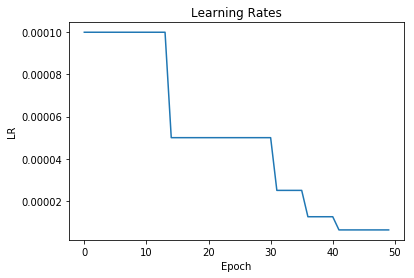

In [0]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(hist_cnn.history['lr'])
plt.title('Learning Rates')
plt.ylabel('LR')
plt.xlabel('Epoch')

Given the changes in learning rates. We finally look at how the model has learned across time.

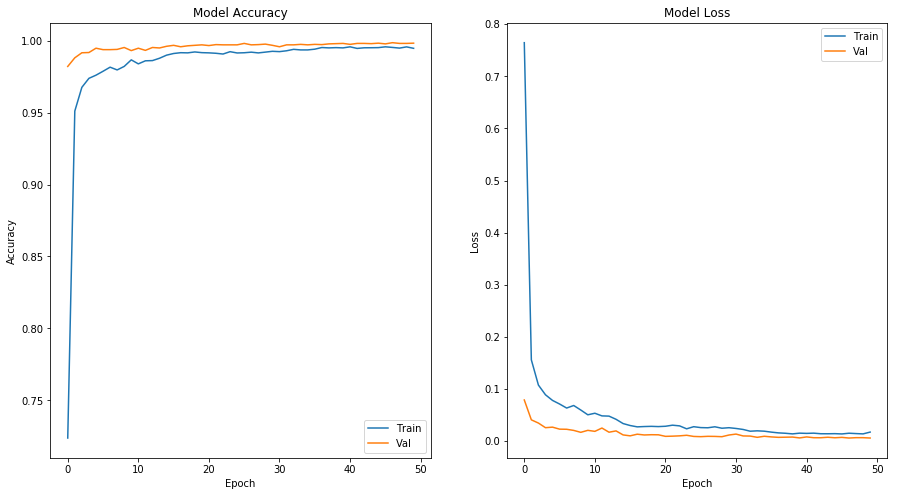

In [0]:
#graph accuracy and loss
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_size_inches(15,8)

plt.subplot(1, 2, 1)
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.subplot(1, 2, 2)
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.show()

Across the epochs, we see that the model learns really quickly -- this may come from the use of minibatches in learning. Moreover, we see that at any epoch, the generalization performance is better. This can be attributed to the data augmentation implemented, as well as the number of features that the model generates, thanks to the VGG framework.

Furthermore, it can be observed that the ANN is still capable of learning on the training set while maintaining its validation performance, as seen from epochs 20 to 50. This quality is important because the model is still picking up knowledge from the augmented data and this can be applied to other unseen data without compromising its performance on the given validation set. This shows promise for the test set. 

To illustrate the difference between using an LR scheduler, we compare the plots above with the plots below for the same model with no LR scheduler. 

<img src = "img/nolr.png" width =800>

We can notice in the figure above that without an LR scheduler, the plots are less smooth and are more separated. This means that we do not get the learning benefit for having a decreasing LR when the models plateau.

### Submission Results
To submit the models, we in our group have created our own accounts to take advantage of the limited number of submissions per day. From this, we have devised strategies and have consulted each other in improving our models. 

To submit, the test dataset was downloaded and pre-processed accordingly. Then, the model with the least validation loss was loaded into the ANN and was used in clasifying. The submission file was then generated.

In [0]:
test = pd.read_csv('../input/Kannada-MNIST/test.csv')

test = test.drop(['id'],1)
x_test = np.array(test/255)
x_test = x_test.reshape(x_test.shape[0],28,28)
x_test = x_test.reshape(x_test.shape[0],28,28,1)

cnn.load_weights("bestweights.hdf5")
results=cnn.predict(x_test)
results=np.argmax(results, axis=1)
cnn3 = pd.DataFrame({'label':results}).reset_index().rename(columns = {'index':'id'})
cnn3.to_csv('cnn3_img_aug.csv',index = False)

Upon submission, the model presented above have performed with a rank of **4th** overall, and the accuracy on the test set is actually the **2nd** highest. 

<img src = "img/lead.png" width = 600>

After reaching the current standing in the leaderboard, it was found that it was actually hard to improve on the model further without trial and error. Since the goals of the midterm project were already reached, this can be a good time to stop. 

## Conclusions
In this project, we have built a classifier for the Kannada MNIST dataset with a performance that is quite competitive. To arrive at this model, we have explored solutions for a familiar problem with lots of readily available solutions. While it was easy to implement solutions we already know, the major issue of **improving generalization performance** has been the biggest hurdle. This was fixed through the use of several regularizers and the research of established architectures for ANNs. 

Moving forward, it would be interesting to come up an architecture that would maximize on the available computing resources provided by the contest platform, such as limited number of submissions per day, and limited GPU time per week. In competitions such as this one, it can be beneficial for participants to be able to generate an adequate model with the minimized computing costs. 